#### Introduction
This is a working notebook for my Udacity Machine Learning Engineer Nanodegree capstone project and is kept here as a record of the process I took completing the project. It is built around the proivided project template, and includes everything I tried for the project regarldess of inclusion in the final report.

The complete code for constructing the merged dataset is found in mergeIPEDSCSC.py, and the project report itself is "Project Report.pdf"

# Analysis of the Sources of Financial Burden on Students Acquiring Upper Education
## Machine Learning Engineer Nanodegree
Corey Bofill
September, 2016

## I. Definition

### Project Overview
Job-seekers today are facing increased demand for higher education for jobs that even recently were lower level. At the same time students are graduating with more debt than their peers were just a few decades ago. The cost of attending college is increasing at a much faster rate than general inflation.<sup>1</sup> Many graduates are left not only with substantial debt, averaging $37,172 for graduates of 2016,<sup>2</sup> but also are faced with a job market that, while starting to see improvement this year, is competitive and often over-saturated. Roughly half of recent college graduates are underemployed, meaning they are in a job where more than half of workers with that job don't think a degree is required.<sup>3</sup> At the same time the overwhelming majority of new jobs go to college graduates.<sup>4</sup> With such high demand for degrees, lowering the financial burden of attending college is crucial to ensuring the future financial success of young adults.  

The College Scorecard (CSC) is a dataset that provides prospective students useful information on colleges. It consists of federal data from undergraduate degree-granting institutions of higher education in the US, including costs and financial aid awards for students, and incomes and loan repayment rates for graduates, amongst others. Data are currently available from 1996 to 2013.<sup>5</sup> The IPEDS Analytics: Delta Cost Project Database is a longitudinal dataset derived from the Integrated Postsecondary Education Data System (IPEDS) data with a focus on revenues and expenditures. Data are available from 1987 to 2012.<sup>6</sup> The CSC dataset draws from the IPEDS and includes the IPEDS Unit ID for each institution, making the two datasets compatible.

### Problem Statement

This project constructs a model of degree granting institutions. This model shows the relationship between the features of an institution and the cost/benefit to that institution's graduates. I then use this model to analyze and determine which features have the greatest impact.  

I use data on student debt and post-graduation earnings from the CSC dataset combined with data on degree awards from the IPEDS dataset to create a single metric representing overall financial burden. I then use data on institution revenue, expenses, financial aid, scholarship spending, faculty, and graduation rates from the IPEDS dataset to construct a supervised random forest model. This model maps the institutional financial data to financial burden. I then use the resulting model to analyze feature importance and demonstrate which institutional features are most relevant to student burden.

### Metrics  
To measure feature importance I apply a variable permutation technique which removes the predictive contribution of one feature within the model, and then measure the change in the mean squared error of the model’s predictions. Mean squared error (MSE) is the average of the squared difference between a model’s predictions and the true values of what is being predicted. It provides a straightforward measure of the model’s accuracy, which is useful because I am concerned less with the overall success of the model as I am with the effects of individual features on the model’s predictive power.

## II. Analysis

### Data Exploration  
The data comes from the CSC and IPEDS datasets from 1997 to 2012. To begin exploring the data I'll load the IPEDS dataset.

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

RANDOM_STATE = 40

#### IPEDS
The IPEDS dataset is provided in two csv files, one for 1987-99 and one for 2000-12. I'll be using the IPEDS created Unit ID, named 'unitid', and the described academic year, 'academicyear', to index the data.

In [2]:
ipeds = pd.read_csv("delta_public_00_12.csv", sep=',',index_col=['unitid','academicyear'])
ipeds.index.names = ['unitID','year']

C:\Users\Charizard\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


For now we'll ignore the dtype warning and take a look at the shape of the dataset.

In [3]:
print "The 2000-12 portion of the IPEDS dataset contains {} total entries for {} institutions and describes {} features. \n".format(
    ipeds.shape[0],len(ipeds.index.levels[0]),ipeds.shape[1])

The 2000-12 portion of the IPEDS dataset contains 87560 total entries for 10568 institutions and describes 972 features. 



Information on each feature is provided by the dataset's curators in a data dictionary. Notably a good deal of the columns (about 400) are flags for whether data has been imputed. I selected the relevant features of the data, sorted below into categories, which will be used to describe an institution, i.e. the input to the model. The categories are comprehensive groupings of what the data dictionary refers to as 'Source'. The categories themselves aren't used in model construction, they don't represent any analytics based feature selection, but they are helpful for getting an understanding of the dataset.

In [2]:
ipeds_characteristics = ['iclevel','control','census_region','flagship','landgrnt','hbcu','hsi','medical','hospital']
ipeds_revenue = ['tuition01','tuition02','tuition03','nettuition01','net_student_tuition','federal03','state03','local03',
                 'state_local_app','federal07','federal07_net_pell','state06','local06','state_local_grant_contract','federal10',
                 'federal10_net_pell','state09','fed_state_loc_grants_con','private03','affiliate01','investment01','endowment03',
                 'priv_invest_endow','edactivity03','auxiliary03','hospital03','other03','other04','independent03','other05',
                 'auxother_rev','stable_operating_rev','total03_revenue','tot_rev_wo_auxother_sum','tot_rev_w_auxother_sum',
                 'unrestricted_revenue','restricted_revenue','tuition_reliance_a1','tuition_reliance_b1','tuition_reliance_c1',
                 'tuition_reliance_a2','tuition_reliance_b2','tuition_reliance_c2','govt_reliance_a','govt_reliance_b',
                 'govt_reliance_c']
ipeds_scholarships_fellowships = ['appliedaid01','appliedaid02','grant01','grant02','grant03','grant04','grant05','grant06',
                                  'grant07','institutional_grant_aid','institutional_grant_aid_share','tuition_discount']
ipeds_expenditures = ['instruction01','instruction01_fasb','instruction02','research01','research01_fasb','research02','pubserv01',
                      'pubserv01_fasb','pubserv02','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01','studserv01_fasb',
                      'studserv02','instsupp01','instsupp01_fasb','instsupp02','opermain01','opermain01_fasb','opermain02',
                      'depreciation01','grants01u','grants01r','grants01','grants01_fasb','auxiliary01','auxiliary01_fasb',
                      'auxiliary02','hospital01','hospital01_fasb','hospital02','independ01','independ01_fasb','independ02',
                      'otheroper01','otheroper02','totaloper01','totaloper02','totaloper03','totaloper04','totaloper05',
                      'interest01','othernon01','othernon02','other01','other01_fasb','other02','totalnon01','totalnon02',
                      'total01','total02','total03_expenses','total04','total05','total06','total07','eandg01','eandg01_sum',
                      'eandg01_w_auxother_sum','eandg02','eandg03','eandg03a','eandg03b','eandg04','eandg05','eandg06','eandg07',
                      'eandg08','rschpub01','acadinststud01','acadinstsupp01','education_share','noneducation_share',
                      'other_ed_related_cost','instruction_share','studserv_share','admin_share','eandr','eandr_degree',
                      'eandr_completion','research_share','research_related_cost','pubserv_share','pubserv_related_cost',
                      'research_pubserv_grants','auxother_cost','sticker_subsidy','average_subsidy','sticker_price_share',
                      'nettuition_share','average_subsidy_share','gross_auxiliary_margin','gross_auxiliary_margin_percent',
                      'gross_operating_margin','fringe_benefit_play','fringe_benefit_play_imp','instr_sal_as_pct_instrtot',
                      'labor_share_of_instructcost','research_sal_as_pct_restot','labor_share_of_rescost',
                      'acadsupp_sal_as_pct_acadsupptot','labor_share_of_acadsuppcost','studserv_sal_as_pct_studservtot',
                      'labor_share_of_studservcost','instsupp_sal_as_pct_instsupptot','labor_share_of_instsuppcost',
                      'pubserv_sal_as_pct_pubservtot','labor_share_of_pubservcost']
ipeds_assets = ['assets06','liabilities07','assets11','land04','buildings05','equipment05','assets15','endow02m','assets16']
ipeds_faculty = ['conthoursug','credhoursgr','credhoursug','ftall1','ftall3','ftall4','ftall5','ftall6','ftall7','ftall8',
                 'ptall1','ptall2','ptall3','ptall4','ptall5','ptall6','ptall7','ptall8','ft_faculty_per_100fte',
                 'pt_faculty_per_100fte','total_executive_admin_managerial','ft_executive_per_100fte','pt_executive_per_100fte',
                 'total_other_professionals','ft_other_professional_per_100fte','pt_other_professional_per_100fte',
                 'total_technical_and_paraprof','ft_technical_per_100fte','pt_technical_per_100fte','total_clerical_secretarial',
                 'ft_clerical_per_100fte','pt_clerical_per_100fte','total_skilled_craft','ft_skilled_per_100fte',
                 'pt_skilled_per_100fte','total_service_maintenance','ft_service_per_100fte','pt_service_per_100fte',
                 'ft_exec_admin_man_share','ft_other_professional_share','ft_technical_paraprof_share',
                 'ft_clerical_secretarial_share','ft_skilled_craft_share','ft_service_maintenance_share','total_faculty_all',
                 'full_time_employees','full_time_employee_share','all_employees','ft_faculty_salary','full_time_employee_100fte',
                 'full_time_faculty_share','faculty_instr_headcount','salarytotal']
# A portion of completions was folded into the output variable, and as such all completion data was excluded from the input
"""ipeds_completions = ['associatedegrees','bachelordegrees','masterdegrees','doctordegrees','firstprofdegrees','awardslessthan1yr',
                     'awards1yrto2yr','awards2yrto4yr','postbacccertificates','postmastcertificates','firstprofcertificates',
                     'postmastFPcert','totaldegrees','totaldegrees_100fte','totalawards','totalcertificates',
                     'certificates_awards_100fte','totalcompletions','totalcompletions_100fte','assoc_deg_share_of_tot_deg',
                     'bach_deg_share_of_tot_deg','grad_deg_share_of_tot_deg','doc_deg_share_of_tot_deg',
                     'prof_deg_share_of_tot_deg']"""
ipeds_graduation_rates = ['grad_rate_150_n','grad_rate_150_p','grad_rate_adj_cohort_n','grad_rate_150_n4yr','grad_rate_150_p4yr',
                          'grad_rate_adj_cohort_n4yr','grad_rate_150_n2yr','grad_rate_150_p2yr','grad_rate_adj_cohort_n2yr']
ipeds_enrollment = ['ugentering','ftretention_rate','ptretention_rate','fall_cohort_num','fall_cohort_pct',
                    'fall_cohort_num_indistrict','fall_cohort_pct_indistrict','fall_cohort_num_instate','fall_cohort_pct_instate',
                    'fall_cohort_num_outofstate','fall_cohort_pct_outofstate','fall_cohort_num_resunknown',
                    'fall_cohort_pct_resunknown','fall_total_undergrad','year_cohort_num','year_cohort_pct','year_total_undergrad',
                    'ft_first_time_first_yr_deg_seek','other_full_time','total_full_time_undergraduates',
                    'returning_to_total_undergraduate','total_full_time_first_prof','total_full_time_graduates',
                    'total_full_time_postbacc','total_full_time','pt_first_time_first_yr_deg_seek','other_part_time',
                    'total_part_time_undergraduates','total_part_time_first_prof','total_part_time_graduates',
                    'total_part_time_postbacc','total_part_time','total_undergraduates','total_graduates','total_first_prof',
                    'total_postbacc','total_enrollment','total_enrollment_amin_tot','total_enrollment_asian_tot',
                    'total_enrollment_black_tot','total_enrollment_hisp_tot','total_enrollment_white_tot',
                    'total_enrollment_multi_tot','total_enrollment_unkn_tot','total_enrollment_nonres_tot',
                    'ftug_share_of_total_ft_enrl','ptug_share_of_total_pt_enrl']

ipeds_degree_proportions = ['assoc_deg_share_of_tot_deg','bach_deg_share_of_tot_deg','grad_deg_share_of_tot_deg',
                            'doc_deg_share_of_tot_deg','prof_deg_share_of_tot_deg']

hepi_scalar = ['hepi_scalar_2012']

# Complete relevant feature list of IPEDS data
ipeds_features = (ipeds_revenue + ipeds_scholarships_fellowships + ipeds_expenditures + ipeds_assets + ipeds_faculty + 
                  ipeds_graduation_rates + ipeds_enrollment + ipeds_characteristics)# + ipeds_completions)

In [5]:
print "ipeds_characteristics:", len(ipeds_characteristics)
print "ipeds_revenue:", len(ipeds_revenue)
print "ipeds_scholarships_fellowships:", len(ipeds_scholarships_fellowships)
print "ipeds_expenditures:", len(ipeds_expenditures)
print "ipeds_assets:", len(ipeds_assets)
print "ipeds_faculty:", len(ipeds_faculty)
#print "ipeds_completions:", len(ipeds_completions)
print "ipeds_graduation_rates:", len(ipeds_graduation_rates)
print "ipeds_enrollment:", len(ipeds_enrollment)

ipeds_characteristics: 9
ipeds_revenue: 46
ipeds_scholarships_fellowships: 12
ipeds_expenditures: 109
ipeds_assets: 9
ipeds_faculty: 53
ipeds_graduation_rates: 9
ipeds_enrollment: 47


|Feature Type|Describes|Feature Count|
|------------|-----------|-----|
|Characteristics|Categorical variables describing the type of institution|9|
|Revenue|Money coming into the institution|46|
|Scholarships and Fellowships|Money distributed as student aid through the institution|12|
|Expenditures|Money being spent by the institution|109|
|Assets|Value of assets owned or controlled by the institution|9|
|Faculty|Institution employment|53|
|Graduation Rates|How many and how quickly students are graduating|9|
|Enrollment|Profile of students attending institution|47|
|**Total**| |**294**|
The HEPI scalar is a calculated value based on the Higher Education Price Index, a measure of the inflation rate applicable to higher education in the U.S. It will be used to scale dollar amounts to static 2012 dollars throughout the project.

Below is the mapping of the Characteristic type categories:  

|Feature|Value|Category| |Feature|Value|Category|
|-------|-----|--------|-|-------|-----|--------|
|iclevel|1|4-year or higher||census_region|1|Northeast|
||2|2- but-less-than 4-year|||2|Midwest|
||3|Less than 2-year|||3|South|
|control|1|Public|||4|West|
||2|Private nonprofit|||5|Islands|
||3|Private for-profit||landgrnt|1|Land grant |
|flagship|1|Flagship |||2|Not land grant |
||0|Not flagship ||medical|1|Grants medical degree|
|hbcu|1|Historically Black College or University|||2|Does not grant medical degree|
||2|Not historically Black College or University||hospital|1|Has a hospital|
|hsi|1|Hispanic Serving Institution|||2|Does not have a hospital|
||0|Not Hispanic Serving Institution|||0|Implied it does not have a hospital|



The feature list can be used to create a dataframe that only describes the desired part of the IPEDS database.

In [6]:
ipeds_relevant = ipeds.loc[:,ipeds_features]

# Append a flag for the source of the data
from_ipeds = pd.Series(data=[1]*ipeds_relevant.shape[0],index=ipeds_relevant.index)
ipeds_relevant['from_ipeds'] = from_ipeds

#print ipeds_relevant.head()

#### CSC  
The CSC dataset is provided in seperate files per year. To take a look at the structure of the data I'll load the most recent which also intersects with the IPEDS dataset.

In [7]:
csc_csv = "MERGED2000_PP.csv"

# Inexplicably there is a zero width no-break space in the UnitID header
csc = pd.read_csv(csc_csv, sep=',',index_col='﻿UNITID')
csc.index.names = ['unitID']

# Create a repeating series of the file's year with indices matching the file
year = pd.Series(data=[int(csc_csv[6:10])]*csc.shape[0],index=csc.index)

# Append it to the dataframe, then drop it into the index
csc['year'] = year
csc.set_index('year',append=True,drop=True,inplace=True)

C:\Users\Charizard\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Again we'll worry about the warning later. For now we'll take a look at the shape of the data. Since the file is specifically for 2012 we know each entry is for a unique institution.

In [8]:
print "The 2000 portion of the CSC dataset contains entries for {} institutions and describes {} features. \n".format(
    csc.shape[0],csc.shape[1])

The 2000 portion of the CSC dataset contains entries for 6478 institutions and describes 1728 features. 



For the output I create a measurement of the cost to a student for acquiring a degree at a given institution. The features I use to do this are:  

1) GRAD_DEBT_MDN - The median debt upon entering repayment for students who graduated. From CSC.  
2) gt_25k_p[y] - The percentage of students making over \$25,000 a year at y years after enrollment. From CSC.  
3) [t]_deg_share_of_tot_deg – The percentage of degrees awarded of type t. Types include associates, bachelors, masters, doctorates, and first professional degrees. From IPEDS.  

The first feature measures the continued financial burden a student carries after leaving an institution. The second is a measure of the value of acquiring a degree – $25k is the median salary of a person 25-34 years old with only a high school degree, so the feature describes the proportion of graduates making more money having acquired a degree compared to had they not. Unfortunately, the reports of this feature are staggered by year so there is little information on how it changes over time, but it makes for a good baseline of the value imparted by an institution. The third measures the proportions of degrees awarded by an institution and can be used to estimate the average time to graduate from that institution, as each type of degree requires a specific minimum number of years of education.  

The third feature is drawn from the IPEDS data, but the first two are from the CSC dataset.

In [9]:
csc_features= ['GRAD_DEBT_MDN','gt_25k_p6','gt_25k_p7','gt_25k_p8','gt_25k_p9','gt_25k_p10']

Once again I create a dataframe containing only the features relevant to the project.

In [10]:
csc_relevant = csc.loc[:,csc_features]

#### Combined Dataset  
Now that we have our rough feature selection done on both datasets we can combine them.

In [2]:
# Merge IPEDS and CSC data
merged_data = csc_relevant.merge(ipeds_relevant,left_index=True,right_index=True,how='inner')
print merged_data.shape

NameError: name 'csc_relevant' is not defined

This shows we have 5326 entries that are the intersection of the IPEDS data with the 2012 CSC data.

#### Selecting Entries With Output
The final step in preparing the dataset is to select only the entries which contain output data, i.e. the threshold, median debt, and degree proportion data.

In [14]:
# Remove rows with no data in an output feature
missing_data = []
for unit in merged_data.index.levels[0]:
    if merged_data.loc[unit,['gt_25k_p6','gt_25k_p7','gt_25k_p8','gt_25k_p9','gt_25k_p10']].isnull().all().all():
        missing_data.append(unit)
    elif merged_data.loc[unit,:]['GRAD_DEBT_MDN'].isnull().all():
        missing_data.append(unit)
    elif merged_data.loc[unit,ipeds_degree_proportions].isnull().all().all():
        missing_data.append(unit)
trimmed_data = merged_data.drop(missing_data, level='unitID')

Earlier I ignored some DtypeWarnings while reading csv files. These are caused by columns having mixed types that can't be cast together, e.g. strings that can't be cast as floats. Now I'll take a closer look at where it's coming up. Columns that can't be cast as one type are instead cast as the 'object' type, and we can use this to see which columns need attention.

In [15]:
mixed_type = []
for column in merged_data:
    if merged_data[column].dtype == 'object':
        mixed_type.append(column)

# Check what values are causing type issues        
for value in merged_data[mixed_type[0]]:
    try:
        float(value)
    except:
        print value

PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySuppressed
PrivacySup

The entries of 'PrivacySuppressed' are causing the warning. Checking the data dictionary shows that all of these mixed type columns should be numeric, so using pd.to_numeric we can cast them to float. Any 'PrivacySuppressed' values can be considered missing data and coerced to NaN.  

In [16]:
for column in mixed_type:
    merged_data[column] = pd.to_numeric(merged_data[column],errors='coerce')

### Complete Dataset
This merged data represent the intersection of all features from the IPEDS and CSC datasets that I'm interested in. I've repeated this process for the entirety of the data, creating 'MergedDataset.csv'.

In [3]:
data = pd.read_csv('MergedDataset.csv', sep=',',index_col=['unitID','year'])

In [4]:
data.shape

(52840, 306)

In [203]:
data.iloc[:,range(0,5)].describe()

,acadinststud01,acadinstsupp01,acadsupp01,acadsupp01_fasb,acadsupp02
count,6.339400e+04,6.042200e+04,4.125300e+04,2.465900e+04,3.661900e+04
mean,1.904906e+07,1.360917e+07,8.717911e+06,9.382099e+06,4.761678e+06
std,5.228226e+07,4.155264e+07,2.722640e+07,3.311490e+07,1.531347e+07
min,0.000000e+00,-7.218947e+06,2.182707e+01,1.000000e+02,3.000000e+00
25%,1.852889e+06,1.202415e+06,8.293812e+05,7.907355e+05,4.731095e+05
50%,6.177273e+06,4.072854e+06,2.248671e+06,2.198715e+06,1.217448e+06
75%,1.634433e+07,1.076039e+07,6.179581e+06,6.070607e+06,3.285189e+06
max,2.055708e+09,1.822956e+09,7.297660e+08,7.765980e+08,5.134040e+08


As shown above this dataset consists of 294 features for 52840 entries. 

The count feature shows that a significant amount of data is missing. None of the five features above have data for every entry and acadsupp01_fasb has data for roughly a third of the entries. Some of these are data that were not been reported, but others were deliberately withheld for privacy purposes. Additionally acadinstsupp01 has a minimum value of -7.2e6. This feature is created by subtracting studserv01, expenditures on student services, from acadinststud01, expenditures on academic and institutional support and student services. Since acadinststud01 is supposed to include student services a negative result should not be possible. This may be a clerical error, or caused by missing data in one feature but not the other, but regardless of the source the result is that the entry is not reliable.

### Exploratory Visualization

To further understand the data, a histogram is shown of one of the output features: the percentage of graduates making over $25k per year, 10 years after enrollment. We can see that for most institutions about 60-80% of graduates meet the threshold, i.e. have a higher salary than the typical worker without a degree.

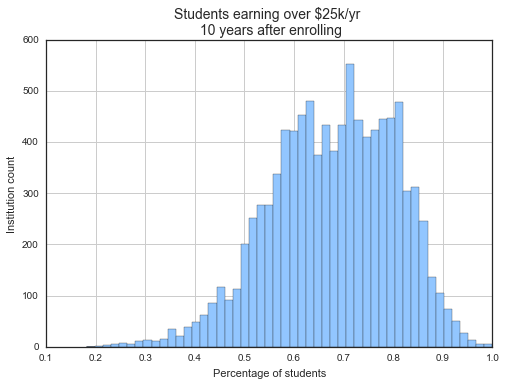

In [176]:
data.hist(column='gt_25k_p10',bins=50,color='b')
plt.title('Students earning over $25k/yr \n 10 years after enrolling',size=14)
plt.ylabel('Institution count')
plt.xlabel('Percentage of students');

This is also called threshold earnings, and aims to show how many students are making more for having recieved a higher education than they would have had they not. The median is at 64%, meaning that attending a typical institution only results in a higher salary two thirds of the time. This isn't a perfect measure, for example $25k is somewhat arbitrary and kept static relative to year without inflation adjustments, but it shows that higher education is not a guarantee of a higher salary.

Something else to note about the data is that many of the features are related to or computed from one another. As an example I've taken the portion of data on graduation rates and constructed a scatter matrix below.

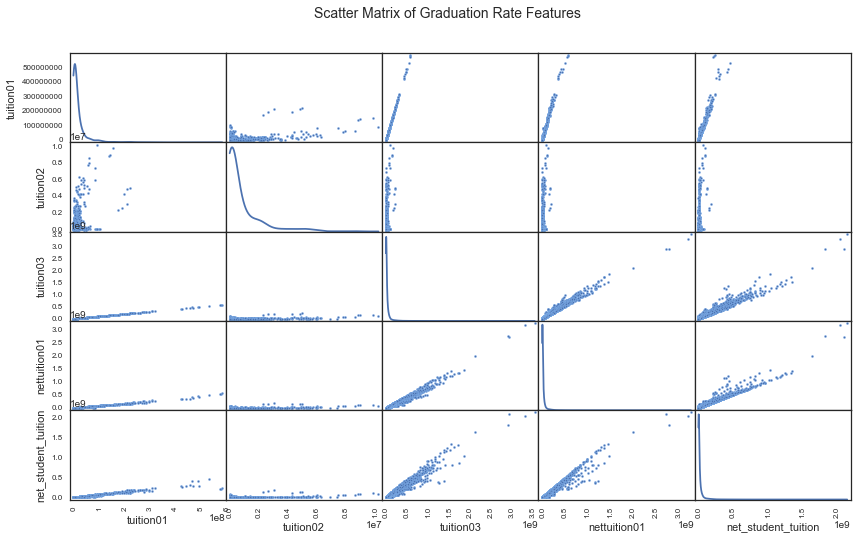

In [185]:
grad_rate_features = ['tuition01','tuition02','tuition03','nettuition01','net_student_tuition']
m = pd.scatter_matrix(data.loc[:,grad_rate_features], alpha = 1., figsize = (14,8), diagonal = 'kde',color='b');
plt.suptitle('Scatter Matrix of Graduation Rate Features',size=14);

This matrix plots each feature against each other, showing their interrelations. The clear linear shapes that occur are evidence of correlation between the features. Correlations between features can have many undesired consequences if not accounted for. Many algorithms and techniques are sensitive to structures like these within the input space.

### Algorithms and Techniques
For the model I use a Random Forest Regressor (RFR), which makes predictions using the aggregate estimations of an ensemble of decision trees. Decision trees on their own are prone to overfitting, i.e. predicting based too heavily on the training data and generalizing to new data poorly. Random Forest mitigates this issue by aggregating the predictions of many trees built on randomly determined subsets of the dataset. I use the scikit-learn implementation<sup>7</sup>, which builds individual trees using an optimized version of the CART algorithm.<sup>8</sup> Random forests are resilient to the form the data takes, such as scale or normality, which makes it a good candidate for a dataset with features of varied types such as the one I’m using. Most of the parameters involved in individual tree construction are left at the default values; however, there are a few which are especially pertinent to my goal:

|Parameter|Description|Default|
|---------|-----------|-------|
|n_estimators|The number of individual trees in the ensemble to contribute to the aggregated prediction. Generally more is better.|10|
|max_features|The number of features to consider when looking for the best split during construction of a decision tree. Using a subset of the total feature space reduces variance in the model, helping counteract the tendency of decision trees to overfit.|‘auto’ (n_features)|
|bootstrap|Whether or not to re-use samples when constructing decision trees. Typically this improves model performance by reducing variance.|True|


I use two standard techniques are to improve the model: data withholding and ideal parameter grid search with cross validation. The former withholds a portion of the data for testing purposes, helping to avoid overfitting to the training data. The latter fits the model using all combinations of potential parameter settings to find the ideal combination. These are implemented using scikit-learn’s train_test_split and GridSearchCV, respectively.
To measure feature importance I use the permutation method described by Strobl (2009).<sup>9</sup> Rather than scikit-learn’s feature_relevance_ attribute, which measures importance by averaging the number of samples affected by a feature across the ensemble, each feature is measured by the following steps:
A) Measure the predictive power of the model
B) Permute (scramble) the feature across all samples, disassociating the feature’s information contribution to the prediction
C) Measure the predictive power of the model on the permuted data
The difference between the measurements in (A) and (C) is the contribution of the feature to the predictive power of the model. This method has significantly less bias than the implementation’s default method, provided there is no use of bootstrap sampling.<sup>10</sup>

### Benchmark
I used the guidelines for permutation variable relevance described by Strobl et. al. (2009)<sup>9</sup>:  

"All variables whose importance is negative, zero or has a small positive value that lies in the same range as the negative values, can be excluded from further exploration. The rationale for this rule of thumb is that the importance of irrelevant variables varies randomly around zero. Therefore positive variation of an amplitude comparable to that of negative variation does not indicate an informative predictor variable, while positive values that exceed this range may indicate that a predictor variable is informative."

## III. Methodology

### Data Preprocessing

#### Remove Erroneous Entries
The data contains entries that fall outside the possible range of values for a feature, such as the example of a negative value entered for a non-negative feature described during data exploration. Without more information on the cause of the error these data cannot be interpreted, and I set such entries to ‘nan’ to match other missing data.

In [25]:
from scipy.stats import skew

z = data.fillna(0)
skness = skew(z)
for item in skness:
    if abs(item) > 200:
        print item

210.744186044
-229.860682572
225.981277867
226.566215875
217.132238123
225.82128947
226.462638416
219.859929092
226.370928791
223.738407956
227.789041033
229.860682354
229.860584838


Taking a closer look at one of these features we can see an entry that, despite being in a feature of percentages, is over 400. Entries like this must be erroneous, and will need to be removed.

In [27]:
data['acadsupp_sal_as_pct_acadsupptot'].describe()

count    35517.000000
mean         0.567295
std          2.304510
min          0.000567
25%          0.460635
50%          0.541898
75%          0.626166
max        425.549801
Name: acadsupp_sal_as_pct_acadsupptot, dtype: float64

I don't need to remove statistical outliers so the only way to identify erroneous entries is by what the feature is supposed to be. Any entries that fall outside their range should be removed.

In [4]:
# Features which should be non-negative
non_negative = ['tuition01','tuition02','tuition03','nettuition01','net_student_tuition','federal03','state03','local03',
                'state_local_app','federal07','federal07_net_pell','state06','local06','state_local_grant_contract','federal10',
                'federal10_net_pell','state09','fed_state_loc_grants_con','private03','affiliate01','investment01','endowment03',
                'priv_invest_endow','edactivity03','auxiliary03','hospital03','other03','other04','independent03','other05',
                'auxother_rev','stable_operating_rev','total03_revenue','tot_rev_wo_auxother_sum','tot_rev_w_auxother_sum',
                'unrestricted_revenue','restricted_revenue','appliedaid01','appliedaid02','grant01','grant02','grant03',
                'grant04','grant05','grant06','grant07','institutional_grant_aid','instruction01','instruction01_fasb',
                'instruction02','research01','research01_fasb','research02','pubserv01','pubserv01_fasb','pubserv02',
                'acadsupp01','acadsupp01_fasb','acadsupp02','studserv01','studserv01_fasb','studserv02','instsupp01',
                'instsupp01_fasb','instsupp02','opermain01','opermain01_fasb','opermain02','depreciation01','grants01u',
                'grants01r','grants01','grants01_fasb','auxiliary01','auxiliary01_fasb','auxiliary02','hospital01',
                'hospital01_fasb','hospital02','independ01','independ01_fasb','independ02','otheroper01','otheroper02',
                'totaloper01','totaloper02','totaloper03','totaloper04','totaloper05','interest01','othernon01','othernon02',
                'other01','other01_fasb','other02','totalnon01','totalnon02','total01','total02','total03_expenses','total04',
                'total05','total06','total07','eandg01','eandg01_sum','eandg01_w_auxother_sum','eandg02','eandg03','eandg03a',
                'eandg03b','eandg04','eandg05','eandg06','eandg07','eandg08','rschpub01','acadinststud01','acadinstsupp01',
                'eandr','eandr_degree','eandr_completion','research_related_cost','pubserv_related_cost',
                'research_pubserv_grants','auxother_cost','sticker_subsidy','average_subsidy','gross_auxiliary_margin',
                'gross_operating_margin','fringe_benefit_play','fringe_benefit_play_imp','assets06','liabilities07','assets11',
                'land04','buildings05','equipment05','assets15','endow02m','assets16','conthoursug','credhoursgr',
                'credhoursug','ftall1','ftall3','ftall4','ftall5','ftall6','ftall7','ftall8','ptall1','ptall2','ptall3',
                'ptall4','ptall5','ptall6','ptall7','ptall8','total_executive_admin_managerial','total_other_professionals',
                'total_technical_and_paraprof','total_clerical_secretarial','total_skilled_craft','total_service_maintenance',
                'total_faculty_all', 'full_time_employees','all_employees','ft_faculty_salary','faculty_instr_headcount',
                'salarytotal','grad_rate_150_n','grad_rate_adj_cohort_n','grad_rate_150_n4yr','grad_rate_adj_cohort_n4yr',
                'grad_rate_150_n2yr','grad_rate_adj_cohort_n2yr','ugentering','fall_cohort_num','fall_cohort_num_indistrict',
                'fall_cohort_num_instate','fall_cohort_num_outofstate','fall_cohort_num_resunknown','fall_total_undergrad',
                'year_cohort_num','year_total_undergrad','ft_first_time_first_yr_deg_seek','other_full_time',
                'total_full_time_undergraduates','returning_to_total_undergraduate','total_full_time_first_prof',
                'total_full_time_graduates','total_full_time_postbacc','total_full_time','other_part_time',
                'total_part_time_undergraduates','total_part_time_first_prof','total_part_time_graduates',
                'total_part_time_postbacc','total_part_time','total_undergraduates','total_graduates','total_first_prof',
                'total_postbacc','total_enrollment','total_enrollment_amin_tot','total_enrollment_asian_tot',
                'total_enrollment_black_tot','total_enrollment_hisp_tot','total_enrollment_white_tot',
                'total_enrollment_multi_tot','total_enrollment_unkn_tot','total_enrollment_nonres_tot']

# Features which are recorded as a percentage from 0.0 to 1.0
percentages = ['tuition_reliance_a1','tuition_reliance_b1','tuition_reliance_c1','tuition_reliance_a2','tuition_reliance_b2',
               'tuition_reliance_c2','govt_reliance_a','govt_reliance_b','govt_reliance_c','institutional_grant_aid_share',
               'tuition_discount','education_share','noneducation_share','other_ed_related_cost','instruction_share',
               'studserv_share','admin_share','research_share','pubserv_share','sticker_price_share','nettuition_share',
               'average_subsidy_share','gross_auxiliary_margin_percent','instr_sal_as_pct_instrtot',
               'labor_share_of_instructcost','research_sal_as_pct_restot','labor_share_of_rescost',
               'acadsupp_sal_as_pct_acadsupptot','labor_share_of_acadsuppcost','studserv_sal_as_pct_studservtot',
               'labor_share_of_studservcost','instsupp_sal_as_pct_instsupptot','labor_share_of_instsuppcost',
               'pubserv_sal_as_pct_pubservtot','labor_share_of_pubservcost','ft_exec_admin_man_share',
               'ft_other_professional_share','ft_technical_paraprof_share','ft_clerical_secretarial_share',
               'ft_skilled_craft_share','ft_service_maintenance_share','full_time_employee_share','full_time_faculty_share',
               'assoc_deg_share_of_tot_deg','bach_deg_share_of_tot_deg','grad_deg_share_of_tot_deg','doc_deg_share_of_tot_deg',
               'prof_deg_share_of_tot_deg','grad_rate_150_p','grad_rate_150_p4yr','grad_rate_150_p2yr','ftretention_rate',
               'ptretention_rate','fall_cohort_pct','fall_cohort_pct_indistrict','fall_cohort_pct_instate',
               'fall_cohort_pct_outofstate','fall_cohort_pct_resunknown','year_cohort_pct','pt_first_time_first_yr_deg_seek',
               'ftug_share_of_total_ft_enrl','ptug_share_of_total_pt_enrl']

# Features given as 'per hundred x'
per_100 = ['ft_faculty_per_100fte','pt_faculty_per_100fte','ft_executive_per_100fte','pt_executive_per_100fte',
           'ft_other_professional_per_100fte','pt_other_professional_per_100fte','ft_technical_per_100fte',
           'pt_technical_per_100fte','ft_clerical_per_100fte','pt_clerical_per_100fte','ft_skilled_per_100fte',
           'pt_skilled_per_100fte','ft_service_per_100fte','pt_service_per_100fte','full_time_employee_100fte']

In [5]:
# Return a series with any out of range values set to nan. Method can be 'non_negative','percent','per_hundred'
def clean_erroneous(series, method):
    err = []
    if method == 'non_negative':
        for value in series:
            if value < 0:
                err.append(value)
    if method == 'percent':
        for value in series:
            # A marginal amount over 1.0 allows for small calculation errors in reporting
            if  value < 0 or value > 1.01:
                err.append(value)
    if method == 'per_hundred':
        for value in series:
            if value < 0 or value > 101:
                err.append(value)
    if len(err) > 0:
        return series.replace(err,float('nan'))
    else:
        return series

In [6]:
# Remove erroneous entries. This was being done later but had to be moved, explanation to follow
data.loc[:,non_negative] = data.loc[:,non_negative].apply(clean_erroneous,method='non_negative')
data.loc[:,percentages] = data.loc[:,percentages].apply(clean_erroneous,method='percent')
data.loc[:,per_100] = data.loc[:,per_100].apply(clean_erroneous,method='per_hundred')

#### Create Dummy Variables  

The values of categorical features are often arbitrary and can misinform the model if treated as numeric. Rather than include them directly I split them into as many features as there are categories, with each new ‘dummy’ variable a binary representation of each category. For example the feature ‘hbcu’, representing whether an institution is a Historically Black College or University, becomes the features ‘hbcu_1.0’ and ‘hbcu_2.0’, each of which may be 1 or 0. An institution that had a 1 in ‘hbcu’ would then have a 1 in ‘hbcu_1.0’ and a 0 in ‘hbcu_2.0’. This turns the 9 categorical features into 26 binary dummy features, bringing the feature total to 311.

In [7]:
# Create dummy features for each categorical feature
categorical_features = ['iclevel','control','census_region','flagship','landgrnt','hbcu','hsi','medical','hospital']
dummy_data = pd.get_dummies(data,columns=categorical_features)

# Make a list of the new dummy features
dummy_features = pd.get_dummies(data.loc[:,categorical_features],columns=categorical_features).columns

### Implementation  

#### Construct Cost Metric
I combine the cost variables into a single metric, defined as  

    burden in years = time to reach wage threshold + debt burden  

‘Time to reach wage threshold’ measures the time starting from enrollment for a graduate to be making more money than had they not attended college. This is done in two steps:  

1) Estimate the average time a student takes to graduate y using the proportion of each type of degree awarded at an institution with the minimum required years for that degree type:  

    y = Σ (degree_share * minimum_required_years)  

2) Estimate the average time to reach the threshold income Y to be the average graduation time y. Iterate through the threshold measurements, updating the estimate with the additional time passed proportional to graduates that remain below the threshold.  

    p_above_threshold * Y + p_below_threshold * years_since_enrollment = Ŷ  

Where Ŷ is the new estimate for the mean time to reach the threshold. This attempts to measure the burden of acquiring a degree at an institution while minimizing the effects of student’s individual characteristics. To this end the debt burden is comprised of the median debt upon graduation divided by the threshold income, representing the burden in years of degree-less labor.

In [8]:
# Returns a pandas series representing the estimated mean cost in years to reach the threshold income
def calculate_mean_year_cost(df):
    mean_year_cost = pd.Series(index=df.index)
    for unit in df.index.levels[0]:
        # List of tuples of percentage values and the year they correspond to
        threshold_means = [(df.loc[unit]['gt_25k_p6'].mean(),6),
                            (df.loc[unit]['gt_25k_p7'].mean(),7),
                            (df.loc[unit]['gt_25k_p8'].mean(),8),
                            (df.loc[unit]['gt_25k_p9'].mean(),9),
                            (df.loc[unit]['gt_25k_p10'].mean(),10)]
    
        # Calculate the average amount of time to graduate using the minimum required time to receive each degree type
        mean_years_to_graduate = np.nansum([df.loc[unit]['assoc_deg_share_of_tot_deg'].mean()*2,
                                           df.loc[unit]['bach_deg_share_of_tot_deg'].mean()*4,
                                           df.loc[unit]['grad_deg_share_of_tot_deg'].mean()*5,
                                           df.loc[unit]['doc_deg_share_of_tot_deg'].mean()*8,
                                           df.loc[unit]['prof_deg_share_of_tot_deg'].mean()*6])
    
        # For each year update the mean cost based on how many students have yet to reach the threshold
        cost_estimate = mean_years_to_graduate
        for t in threshold_means:
            p_above_threshold = t[0]
            p_below_threshold = 1 - t[0]
            years_since_enrollment = t[1]
            cost_estimate = (p_above_threshold*cost_estimate + p_below_threshold*years_since_enrollment)
        
        mean_year_cost.loc[unit] = cost_estimate
        
    return mean_year_cost

In [9]:
dummy_data['mean_year_cost'] = calculate_mean_year_cost(dummy_data)

# Calculate the total cost in years for graduating an institution
dummy_data['cost'] = dummy_data['mean_year_cost'] + dummy_data['GRAD_DEBT_MDN']/25000.
cost_data = pd.DataFrame(data=dummy_data.loc[~dummy_data['cost'].isnull()])

# Initialize a dataframe without combining the output features
#m_cost_data = pd.DataFrame(data=data.loc[~data['mean_year_cost'].isnull()])
#m_cost_data = pd.DataFrame(data=m_cost_data.loc[~data['GRAD_DEBT_MDN'].isnull()])

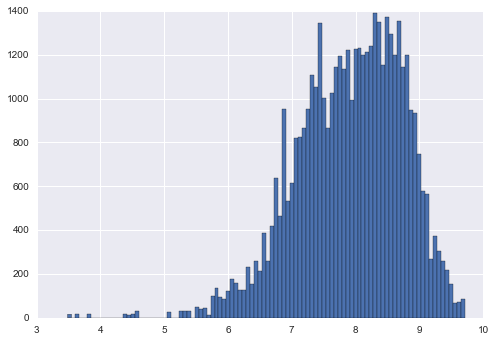

In [31]:
cost_data['mean_year_cost'].hist(bins = 100);

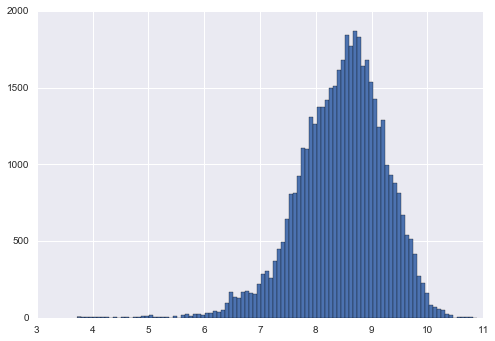

In [32]:
# successive
cost_data['cost'].hist(bins = 100);

#### Sequester Testing Data
Since the model does not bootstrap samples, out-of-bag error estimates for internal cross validation are not available. Instead I sequester a subset of data to test the model on.

In [10]:
# Make a list of input features still in the data after preprocessing
input_features = []
for feature in ipeds_features:
    if feature in cost_data.columns:
        input_features.append(feature)
# Add the dummy features
input_features.extend(dummy_features)

In [91]:
# Make a list of output features
#output_features = ['mean_year_cost','GRAD_DEBT_MDN']

In [11]:
# Create train and test split of data
X = cost_data.loc[:,input_features]
y = cost_data['cost']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

#### Impute Missing Values
Imputation, aka inferring data, is necessary due to the inherent limitations of the modeling tools in handling incomplete data. To determine the best method for imputation I compare the results of a model built with data imputed by feature mean or median, and by zero. My tests show that imputing all values with zero results in the lowest MSE. 

In [180]:
# Simplified after knowing results of tests. Output data needs no imputation.
imputed_data = X_train.fillna(0)

In [167]:
# Method for series-wise imputation. Method can be 'median', 'mean', or 'value' which defaults to 0.0
def impute_series(series,method,value=0.):
    if method == 'median':
        mdn = series.median()
        return series.fillna(mdn)
    elif method == 'mean':
        mean = series.mean()
        return series.fillna(mean)
    elif method == 'value':
        return series.fillna(value)

In [177]:
""" This is for testing imputation methods and won't run in order. To see the results of this code, run this cell, 
then run the model construction, then run the next cell

# Impute training data
imputed_data = X_train.apply(impute_series,method='mean')

# Map imputation for test data transformation
median_map = {}
mean_map = {}
for feature in X_train:
    median_map[feature] = X_train[feature].median()
    mean_map[feature] = X_train[feature].median()
    
"""

In [179]:
"""
# Tranform test data, test on model
imp_test = X_test.copy()
for feature in imp_test.columns:
    imp_test[feature] = impute_series(imp_test[feature],method='value',value=mean_map[feature])

print "MSE: ", mean_squared_error(model.predict(imp_test),y_test)
"""

MSE:  0.274766822228


In [186]:
# Record of MSE of model trained with each method
test_results = {'mean':0.274766822228,'median':0.110023692222,'zero':0.102098303975}

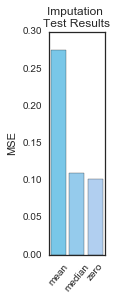

In [52]:
t_df = pd.DataFrame(data={'method':['mean','median','zero'],'values':[0.274766822228,0.110023692222,0.102098303975]})

# Plot results
sns.set(style="white")
sns.set_color_codes("pastel")
sns.set_context(rc={"figure.figsize": (1, 4)})
i = sns.barplot(data=t_df,x='method',y='values',palette=['#67cefa','#87cefa','#a7cefa'])
i.set_xticklabels(['mean','median','zero'],rotation=50,ha='center')
i.set(title='Imputation \nTest Results',ylabel='MSE',xlabel="");

### Construct Model
As described above, I implement the Random Forest regressor using GridSearchCV.

In [181]:
# Initialize and fit model
rfr = RandomForestRegressor(bootstrap=False,random_state=RANDOM_STATE)

""" 
 Testing full set of construction parameters against the default
 Note: 'mse' vs 'mae' was excluded because 'mae' consistently caused a system crash
params = {'n_estimators':[20],'max_features':['sqrt'],'min_samples_split':[2,4],
         'min_samples_leaf':[1,3],'min_weight_fraction_leaf':[0.0,0.001],'max_leaf_nodes':[None,30000],
          'min_impurity_split':[1e-07,1e-06],'warm_start':[False,True]}

 Testing parameters which were not set as default
params = {'n_estimators':[30,70,110],'max_features':['sqrt','log2']}
"""
# Using GridSearchCV like this is redundant, but is left to reflect the process of testing for the optimal parameters
params = {'n_estimators':[130],'max_features':['sqrt']}

scorer = make_scorer(mean_squared_error, greater_is_better=False)

gscv = GridSearchCV(rfr,params,scoring=scorer)

gscv.fit(imputed_data,y_train)

model = gscv.best_estimator_

### Refinement
To refine the model I expand the parameter space of GridSearchCV. This is done in two steps to minimize computation time: first I test each parameter on a small range of values including the default to find if any require closer attention. This confirms that the model only benefits from tuning the parameters discussed above: n_estimators and max_features. Second I test the parameters of interest across a wider range of values to determine the optimal parameter set. Under most circumstances the performance of a Random Forest model will improve with an increase in the number of estimators; however, the diminishing returns of the improvement and the increase in computation time make an arbitrarily large ensemble impractical.  

I measure model performance with a range of estimators and determine an optimal number of estimators to be 130. Similarly, setting max_features to the square root of the total number of features consistently shows the most gain in performance.

In [96]:
# Record of gscv scores for respective n_estimators
test_estimators = [10, 30, 50, 70, 90, 110, 130, 150, 170]
test_scores = [-0.1521217,-0.13289169,-0.12885468,-0.12734679,-0.12640747,-0.12572043,-0.12522685,-0.12518031,-0.12483606]

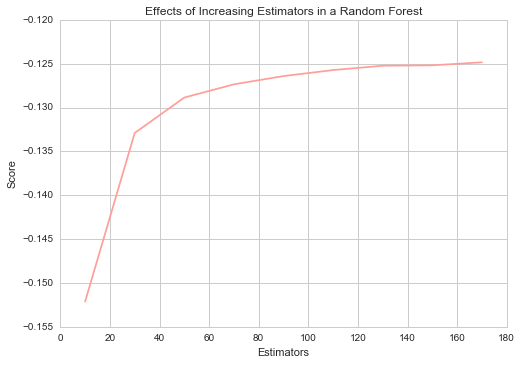

In [104]:
plt.plot(test_estimators,test_scores,color='r')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Effects of Increasing Estimators in a Random Forest');

## IV. Results

#### Model Evaluation and Validation
To evaluate the final model I impute the sequestered testing data using the method determined by the training data, then compute the mean squared error. The model achieves a MSE of 0.1021. While MSE is a useful metric for model performance due to it measuring both bias and variance, it can be difficult to interpret. The square root of the MSE, the root mean square error (RMSE), is in the same units as the output and estimates the standard deviation of the output. The RMSE of the model is 0.3195, which compares favorably to the mean of the output: 8.476.

In [183]:
# Impute missing values in test data
imputed_test = X_test.fillna(0)

In [69]:
# n_estimators = 10
print "R2: ", r2_score(model.predict(imputed_test),y_test)
print "MSE: ", mean_squared_error(model.predict(imputed_test),y_test)
print "Score: ", model.score(imputed_test,y_test)

R2:  0.671250357034
MSE:  0.125158507501
Score:  0.794246926839


In [184]:
# n_estimators = 130
print "R2: ", r2_score(model.predict(imputed_test),y_test)
print "MSE: ", mean_squared_error(model.predict(imputed_test),y_test)
print "Score: ", model.score(imputed_test,y_test)

R2:  0.716411942047
MSE:  0.102098303975
Score:  0.83215651715


#### Residuals Plot
To further evaluate the model I create a visualization of the model’s residuals, the difference between the model’s estimate and the true values. Ideally the residuals will have a uniform distribution, caused by the model explaining all internal structures of the output that are not random. The residuals of my model show a few notable characteristics. The first, the tail on the left, is explained by the distribution of the output data, shown adjacent. Second, the plot shows signs of heteroscedasticity, where the variability of the errors changes relative to the estimate. While the distribution around zero looks normal, as shown on the left of the plot, the model tends to overestimate more from 6-8.   This is typically caused by a problem with the feature space; the model is not accounting for some characteristic of the input. Since Random Forest models are not very sensitive to feature transformation, this is most likely due to some determining feature being absent from the dataset.

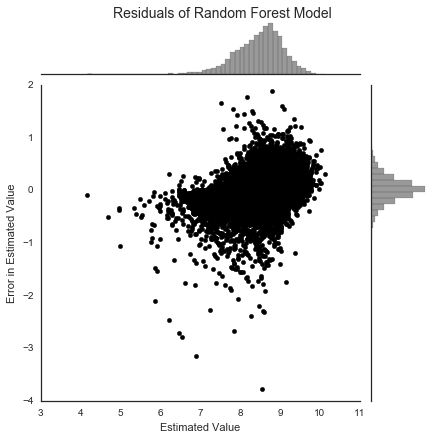

In [164]:
# Plot of residuals for the final model
predictions = model.predict(imputed_test)
residuals = y_test - predictions

sns.set(style="white")
r = sns.jointplot(x=predictions,y=residuals.values,color='black',stat_func=None,xlim=(3,11))
r.set_axis_labels('Estimated Value','Error in Estimated Value')
r.fig.suptitle('Residuals of Random Forest Model',size=14)
r.fig.subplots_adjust(top=.95);

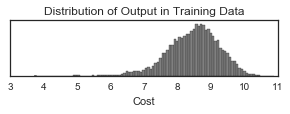

In [167]:
# Plot of the distribution of the output variable in the training data, for reference
cost_data['cost'].hist(bins=100,figsize=(4.8,1),color='gray')
plt.xlabel('Cost')
plt.tick_params(axis='y',labelleft='off')
plt.grid()
plt.title('Distribution of Output in Training Data');

#### Variable Permutation Importance
I implement variable importance permutation to create a list of the features ranked by their contribution to the model’s MSE.<sup>11</sup>  

The scores determined relevant by the benchmark set range from 0.0001 to 0.0283, reflecting an increase in the model’s MSE from 0.1% to over 28%. This wide range is a good indicator of the success of the solution to distinguish features.

In [38]:
# Modified from http://blog.datadive.net/selecting-good-features-part-iii-random-forests/
from collections import defaultdict

# Take a model and testing data and return a tuple list of feature importance
def variable_permutation_score(model,test_input,test_output):
    scores = defaultdict(list)

    # Record the mean squared error for the unmodified test data
    mse = mean_squared_error(test_output, model.predict(test_input))

    # For each column, permute the data and record the change in test score
    for feature in test_input.columns:
        X_copy = test_input.copy()
        np.random.shuffle(X_copy[feature])
        permuted_mse = mean_squared_error(test_output, model.predict(X_copy))
        
        # Record scores as difference between permuted and original score
        scores[feature].append((permuted_mse - mse))
        
    return sorted([(round(np.mean(score), 4), feat) for feat, score in scores.items()], reverse=True)

In [15]:
# Record of permutation scores for unmolested model (to avoid recomputing)
base_model_scores = [(0.0283, 'grant01'), (0.0205, 'net_student_tuition'), (0.0194, 'ft_faculty_salary'), (0.0185, 'total_enrollment_white_tot'), (0.0184, 'total_enrollment_asian_tot'), (0.0147, 'assets16'), (0.0117, 'control_3.0'), (0.0106, 'ft_first_time_first_yr_deg_seek'), (0.0095, 'institutional_grant_aid_share'), (0.0094, 'assets06'), (0.0089, 'auxiliary01'), (0.0089, 'assets15'), (0.0086, 'auxother_rev'), (0.0084, 'grant07'), (0.0079, 'auxiliary03'), (0.0077, 'total_postbacc'), (0.0076, 'ftretention_rate'), (0.0076, 'census_region_1.0'), (0.0074, 'liabilities07'), (0.0073, 'salarytotal'), (0.0069, 'grad_rate_150_p'), (0.0066, 'instruction02'), (0.0066, 'eandg02'), (0.0065, 'control_2.0'), (0.0062, 'private03'), (0.0061, 'unrestricted_revenue'), (0.006, 'total_enrollment_black_tot'), (0.0058, 'total_enrollment_hisp_tot'), (0.0058, 'land04'), (0.0058, 'ftug_share_of_total_ft_enrl'), (0.0057, 'total_part_time_undergraduates'), (0.0057, 'instsupp01'), (0.0056, 'nettuition01'), (0.0056, 'grad_rate_150_n'), (0.0055, 'total_full_time'), (0.0054, 'grant05'), (0.0052, 'total_enrollment_nonres_tot'), (0.0052, 'studserv_share'), (0.0052, 'ptretention_rate'), (0.0052, 'other_part_time'), (0.0051, 'total_undergraduates'), (0.0051, 'eandr'), (0.005, 'tuition03'), (0.005, 'total_part_time'), (0.005, 'total_enrollment'), (0.005, 'federal10'), (0.005, 'federal07'), (0.0049, 'eandr_degree'), (0.0048, 'total_graduates'), (0.0048, 'total_full_time_undergraduates'), (0.0048, 'instruction01_fasb'), (0.0048, 'grad_rate_adj_cohort_n'), (0.0047, 'total_full_time_graduates'), (0.0045, 'total_full_time_postbacc'), (0.0045, 'returning_to_total_undergraduate'), (0.0045, 'instruction01'), (0.0044, 'institutional_grant_aid'), (0.0043, 'total_part_time_postbacc'), (0.0043, 'instruction_share'), (0.0043, 'eandr_completion'), (0.0042, 'studserv01'), (0.0042, 'ptug_share_of_total_pt_enrl'), (0.0042, 'other_full_time'), (0.0042, 'investment01'), (0.0042, 'fringe_benefit_play_imp'), (0.0042, 'acadsupp01'), (0.0041, 'restricted_revenue'), (0.0041, 'opermain01'), (0.004, 'census_region_3.0'), (0.0039, 'priv_invest_endow'), (0.0039, 'grant02'), (0.0039, 'grad_rate_150_p4yr'), (0.0039, 'auxother_cost'), (0.0037, 'total_part_time_graduates'), (0.0037, 'tot_rev_w_auxother_sum'), (0.0036, 'total03_revenue'), (0.0036, 'fall_cohort_num'), (0.0034, 'eandg01_sum'), (0.0034, 'acadinstsupp01'), (0.0033, 'eandg01_w_auxother_sum'), (0.0033, 'assets11'), (0.0032, 'eandg01'), (0.0031, 'tuition_reliance_a2'), (0.0031, 'total_enrollment_unkn_tot'), (0.0031, 'stable_operating_rev'), (0.0031, 'fall_total_undergrad'), (0.0029, 'ugentering'), (0.0029, 'grant03'), (0.0027, 'tuition_reliance_c2'), (0.0027, 'tuition_reliance_b2'), (0.0027, 'total_enrollment_amin_tot'), (0.0027, 'depreciation01'), (0.0027, 'average_subsidy'), (0.0026, 'tuition_reliance_b1'), (0.0026, 'total05'), (0.0026, 'grant06'), (0.0026, 'credhoursug'), (0.0025, 'tuition_reliance_a1'), (0.0025, 'research01'), (0.0025, 'federal07_net_pell'), (0.0025, 'faculty_instr_headcount'), (0.0025, 'credhoursgr'), (0.0025, 'acadinststud01'), (0.0024, 'tuition_discount'), (0.0024, 'total03_expenses'), (0.0024, 'iclevel_1.0'), (0.0024, 'grad_rate_adj_cohort_n2yr'), (0.0024, 'grad_rate_150_n4yr'), (0.0024, 'average_subsidy_share'), (0.0024, 'admin_share'), (0.0024, 'acadsupp01_fasb'), (0.0023, 'studserv02'), (0.0023, 'grad_rate_adj_cohort_n4yr'), (0.0023, 'eandg08'), (0.0023, 'appliedaid01'), (0.0022, 'research_related_cost'), (0.0022, 'iclevel_2.0'), (0.0022, 'hbcu_2.0'), (0.0022, 'hbcu_1.0'), (0.0022, 'govt_reliance_b'), (0.0022, 'fringe_benefit_play'), (0.0022, 'fed_state_loc_grants_con'), (0.0021, 'total01'), (0.0021, 'studserv01_fasb'), (0.0021, 'govt_reliance_c'), (0.0021, 'ft_faculty_per_100fte'), (0.002, 'state09'), (0.002, 'research_pubserv_grants'), (0.002, 'medical_2.0'), (0.0019, 'tuition_reliance_c1'), (0.0019, 'total02'), (0.0019, 'state_local_grant_contract'), (0.0019, 'grad_rate_150_p2yr'), (0.0019, 'auxiliary01_fasb'), (0.0018, 'total04'), (0.0018, 'tot_rev_wo_auxother_sum'), (0.0018, 'state06'), (0.0018, 'research_share'), (0.0018, 'instsupp02'), (0.0018, 'instr_sal_as_pct_instrtot'), (0.0018, 'grad_rate_150_n2yr'), (0.0018, 'federal10_net_pell'), (0.0017, 'total07'), (0.0017, 'sticker_subsidy'), (0.0017, 'state_local_app'), (0.0017, 'instsupp01_fasb'), (0.0017, 'govt_reliance_a'), (0.0017, 'eandg05'), (0.0017, 'census_region_2.0'), (0.0015, 'state03'), (0.0015, 'grants01'), (0.0015, 'edactivity03'), (0.0015, 'auxiliary02'), (0.0013, 'nettuition_share'), (0.0013, 'education_share'), (0.0013, 'eandg03'), (0.0012, 'totaloper01'), (0.0012, 'studserv_sal_as_pct_studservtot'), (0.0012, 'rschpub01'), (0.0012, 'research02'), (0.0012, 'acadsupp02'), (0.0011, 'research01_fasb'), (0.0011, 'other05'), (0.0011, 'other03'), (0.0011, 'noneducation_share'), (0.0011, 'instsupp_sal_as_pct_instsupptot'), (0.0011, 'gross_operating_margin'), (0.0011, 'census_region_5.0'), (0.0011, 'census_region_4.0'), (0.001, 'total_enrollment_multi_tot'), (0.001, 'sticker_price_share'), (0.001, 'pubserv_share'), (0.001, 'opermain01_fasb'), (0.001, 'labor_share_of_instructcost'), (0.001, 'labor_share_of_acadsuppcost'), (0.001, 'gross_auxiliary_margin'), (0.001, 'eandg04'), (0.0009, 'pubserv_related_cost'), (0.0009, 'ptall1'), (0.0009, 'opermain02'), (0.0009, 'medical_-1.0'), (0.0009, 'fall_cohort_num_instate'), (0.0008, 'total_service_maintenance'), (0.0008, 'pubserv01'), (0.0008, 'pt_faculty_per_100fte'), (0.0008, 'other01'), (0.0008, 'labor_share_of_studservcost'), (0.0008, 'labor_share_of_instsuppcost'), (0.0008, 'full_time_faculty_share'), (0.0008, 'control_1.0'), (0.0007, 'full_time_employee_share'), (0.0007, 'ft_service_per_100fte'), (0.0007, 'all_employees'), (0.0007, 'affiliate01'), (0.0007, 'acadsupp_sal_as_pct_acadsupptot'), (0.0006, 'total_faculty_all'), (0.0006, 'pubserv02'), (0.0006, 'full_time_employee_100fte'), (0.0006, 'ftall4'), (0.0005, 'total_other_professionals'), (0.0005, 'pubserv01_fasb'), (0.0005, 'full_time_employees'), (0.0005, 'ftall8'), (0.0005, 'ftall6'), (0.0005, 'ftall3'), (0.0005, 'ftall1'), (0.0005, 'ft_service_maintenance_share'), (0.0005, 'fall_cohort_num_outofstate'), (0.0004, 'year_cohort_num'), (0.0004, 'totaloper02'), (0.0004, 'total_first_prof'), (0.0004, 'total_executive_admin_managerial'), (0.0004, 'total_clerical_secretarial'), (0.0004, 'research_sal_as_pct_restot'), (0.0004, 'local06'), (0.0004, 'labor_share_of_pubservcost'), (0.0004, 'ft_technical_per_100fte'), (0.0004, 'ft_other_professional_per_100fte'), (0.0004, 'ft_clerical_per_100fte'), (0.0004, 'eandg07'), (0.0004, 'appliedaid02'), (0.0003, 'year_total_undergrad'), (0.0003, 'total_technical_and_paraprof'), (0.0003, 'pubserv_sal_as_pct_pubservtot'), (0.0003, 'ptall6'), (0.0003, 'local03'), (0.0003, 'hospital_-1.0'), (0.0003, 'gross_auxiliary_margin_percent'), (0.0003, 'ftall5'), (0.0003, 'ft_technical_paraprof_share'), (0.0003, 'ft_executive_per_100fte'), (0.0003, 'conthoursug'), (0.0002, 'totaloper05'), (0.0002, 'totaloper04'), (0.0002, 'totaloper03'), (0.0002, 'total_full_time_first_prof'), (0.0002, 'ptall5'), (0.0002, 'ptall4'), (0.0002, 'pt_service_per_100fte'), (0.0002, 'pt_clerical_per_100fte'), (0.0002, 'other01_fasb'), (0.0002, 'interest01'), (0.0002, 'hospital_2.0'), (0.0002, 'grants01_fasb'), (0.0002, 'grant04'), (0.0002, 'ftall7'), (0.0002, 'ft_skilled_per_100fte'), (0.0002, 'ft_clerical_secretarial_share'), (0.0002, 'federal03'), (0.0002, 'eandg03a'), (0.0001, 'totalnon01'), (0.0001, 'total_skilled_craft'), (0.0001, 'total_part_time_first_prof'), (0.0001, 'ptall8'), (0.0001, 'ptall3'), (0.0001, 'ptall2'), (0.0001, 'pt_technical_per_100fte'), (0.0001, 'pt_other_professional_per_100fte'), (0.0001, 'othernon01'), (0.0001, 'other04'), (0.0001, 'other02'), (0.0001, 'labor_share_of_rescost'), (0.0001, 'independent03'), (0.0001, 'independ02'), (0.0001, 'independ01_fasb'), (0.0001, 'independ01'), (0.0001, 'iclevel_3.0'), (0.0001, 'hsi_1.0'), (0.0001, 'hospital03'), (0.0001, 'hospital02'), (0.0001, 'hospital01'), (0.0001, 'ft_skilled_craft_share'), (0.0001, 'ft_other_professional_share'), (0.0001, 'ft_exec_admin_man_share'), (0.0001, 'fall_cohort_num_indistrict'), (0.0001, 'equipment05'), (0.0001, 'endowment03'), (0.0001, 'endow02m'), (0.0001, 'buildings05'), (0.0, 'year_cohort_pct'), (0.0, 'tuition02'), (0.0, 'tuition01'), (0.0, 'totalnon02'), (0.0, 'total06'), (0.0, 'ptall7'), (0.0, 'pt_skilled_per_100fte'), (0.0, 'pt_first_time_first_yr_deg_seek'), (0.0, 'pt_executive_per_100fte'), (0.0, 'otheroper02'), (0.0, 'otheroper01'), (0.0, 'othernon02'), (0.0, 'other_ed_related_cost'), (0.0, 'medical_1.0'), (0.0, 'medical_-2.0'), (0.0, 'landgrnt_2.0'), (0.0, 'landgrnt_1.0'), (0.0, 'hsi_0.0'), (0.0, 'hospital_1.0'), (0.0, 'hospital01_fasb'), (0.0, 'grants01u'), (0.0, 'grants01r'), (0.0, 'flagship_1.0'), (0.0, 'flagship_0.0'), (-0.0, 'fall_cohort_pct_resunknown'), (0.0, 'fall_cohort_pct_outofstate'), (0.0, 'fall_cohort_pct_instate'), (0.0, 'fall_cohort_pct_indistrict'), (-0.0, 'fall_cohort_pct'), (0.0, 'fall_cohort_num_resunknown'), (0.0, 'eandg06'), (0.0, 'eandg03b')]

In [30]:
for s in base_model_scores:
    print s

(0.0283, 'grant01')
(0.0205, 'net_student_tuition')
(0.0194, 'ft_faculty_salary')
(0.0185, 'total_enrollment_white_tot')
(0.0184, 'total_enrollment_asian_tot')
(0.0147, 'assets16')
(0.0117, 'control_3.0')
(0.0106, 'ft_first_time_first_yr_deg_seek')
(0.0095, 'institutional_grant_aid_share')
(0.0094, 'assets06')
(0.0089, 'auxiliary01')
(0.0089, 'assets15')
(0.0086, 'auxother_rev')
(0.0084, 'grant07')
(0.0079, 'auxiliary03')
(0.0077, 'total_postbacc')
(0.0076, 'ftretention_rate')
(0.0076, 'census_region_1.0')
(0.0074, 'liabilities07')
(0.0073, 'salarytotal')
(0.0069, 'grad_rate_150_p')
(0.0066, 'instruction02')
(0.0066, 'eandg02')
(0.0065, 'control_2.0')
(0.0062, 'private03')
(0.0061, 'unrestricted_revenue')
(0.006, 'total_enrollment_black_tot')
(0.0058, 'total_enrollment_hisp_tot')
(0.0058, 'land04')
(0.0058, 'ftug_share_of_total_ft_enrl')
(0.0057, 'total_part_time_undergraduates')
(0.0057, 'instsupp01')
(0.0056, 'nettuition01')
(0.0056, 'grad_rate_150_n')
(0.0055, 'total_full_time')
(0.

In [83]:
# Check for features within the irrelevancy range
print len([x for x in base_model_scores if x[0]>0.00009])
print len([x for x in base_model_scores if x[0]<0.00009])

279


32

#### Sensitivity Analysis
To validate the robustness of the model I alter the random state variable of the algorithms used to sequester the data and construct the model. To assure the test results are reliable it is critical to prevent information from the testing data being used in the construction of the model. By keeping the random state constant the training and testing subsets are always the same, and no information leak occurs. Once the model is finalized, the sensitivity of the model to the input space can be tested by altering the random state and thus the subsets of data with which the model is built and tested. This results in a model MSE of 0.1010, showing the model is resilient to perturbations in the data. The feature importance rankings were not perfectly stable – most fell by roughly 0.002-0.004 – however the change was fairly uniform with a few exceptions of features’ scores increasing. This results in a change in the rankings, however the relative scores of each feature are somewhat stable.

In [37]:
# Modified random state
print "R2: ", r2_score(model.predict(imputed_test),y_test)
print "MSE: ", mean_squared_error(model.predict(imputed_test),y_test)
print "Score: ", model.score(imputed_test,y_test)

R2:  0.721331473959
MSE:  0.101037427777
Score:  0.83353761247


In [39]:
# With modified random state
scores = variable_permutation_score(model,imputed_test,y_test)
print "Features sorted by their score:"
for s in scores:
    print s

Features sorted by their score:
(0.0264, 'grant01')
(0.0219, 'total_enrollment_white_tot')
(0.0172, 'ft_faculty_salary')
(0.0164, 'total_enrollment_asian_tot')
(0.0164, 'net_student_tuition')
(0.0154, 'institutional_grant_aid_share')
(0.0116, 'control_2.0')
(0.0105, 'assets16')
(0.0095, 'auxiliary03')
(0.0092, 'ft_first_time_first_yr_deg_seek')
(0.009, 'ftretention_rate')
(0.0085, 'total_postbacc')
(0.0085, 'grant07')
(0.0084, 'control_3.0')
(0.0084, 'auxiliary01')
(0.0083, 'assets06')
(0.0082, 'salarytotal')
(0.0075, 'census_region_1.0')
(0.0074, 'liabilities07')
(0.0074, 'auxother_rev')
(0.0073, 'assets15')
(0.007, 'grad_rate_150_p')
(0.0068, 'total_graduates')
(0.0068, 'total_enrollment_nonres_tot')
(0.0063, 'tuition03')
(0.0062, 'total_enrollment_black_tot')
(0.0061, 'total_part_time_undergraduates')
(0.0061, 'instruction02')
(0.0061, 'institutional_grant_aid')
(0.0059, 'total_undergraduates')
(0.0059, 'acadsupp01')
(0.0058, 'total_enrollment_hisp_tot')
(0.0058, 'grant05')
(0.0057,

### Justification
The benchmark I established states that features with permutation scores that are negative, zero, or as close to zero as any negative scores do not influence the prediction. Of the 311 input features, 32 fell within this range. Thus 279 features had some effect on the model. The scores of these features ranged across four orders of magnitude, and while the rankings of the feature’s relevance are not stable, it does suit the goal of the project which is to provide areas worth further investigation.

## V. Conclusion

### Free-Form Visualization
The variable importance rankings are a measure of how much predictions suffer if the information from that feature is lost while all others are kept the same. To help interpret the feature permutation scores I calculate the correlation between these features and the output. The scale of the correlation alone isn’t helpful, as any information on the feature’s place within the context of the input space is lost; however, the polarity of the correlation provides insight into why the feature is influential. I plot the top ten features colored by the polarity of their correlation with the output. 

In [27]:
from scipy.stats import spearmanr

s_corr = []
for score in base_model_scores:
    s_corr.append(spearmanr(y_train,imputed_data[score[1]]))
corr_sign = np.sign([x[0] for x in s_corr])

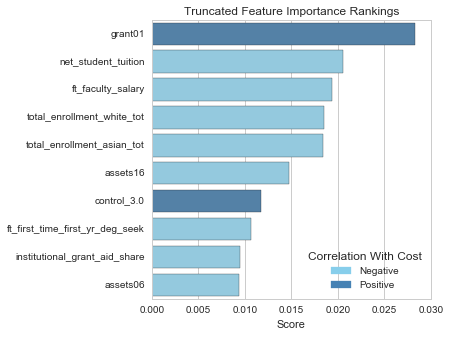

In [153]:
from matplotlib.patches import Patch

sns.set(style="whitegrid")
sns.set_color_codes("pastel")
sns.set_context(rc={"figure.figsize": (5, 5)})

# Create dataframe out of features, importance scores, and correlation scores
rankings = pd.DataFrame(data={'feature':[x[1] for x in base_model_scores],'score':[x[0] for x in base_model_scores],
                              'correlation':corr_sign})

# Set bar color by correlation
palette = ['skyblue' if (correlation < 0) else 'steelblue' for correlation in rankings['correlation'] ]

# Make barplot
b = sns.barplot(data=rankings.loc[rankings['score']>0.009],x='score', y='feature',palette=palette)
b.set(title='Truncated Feature Importance Rankings',ylabel='',xlabel='Score')

# Set legend
handles = [Patch(color='skyblue', label='Negative'),Patch(color='steelblue', label='Positive')]
plt.legend(title= 'Correlation With Cost',labels=['Negative','Positive'],loc='lower right',handles=handles);

While further research would be required to make definitive claims the data suggest some insight: unsurprisingly higher paid faculty benefit students, and private for-profit institutions impart more of a burden. Additionally an interesting pattern is apparent from combinations of other high ranking features. Pell Grants, grants given to students based on financial need, is the highest ranked feature yet it has a positive correlation with cost. This means that institutions that provide more Pell Grants end up imposing more of a financial burden on graduates. This is in contrast to the second ranked feature, net tuition revenue coming directly from students rather than grants, which is inversely correlated with cost. The more students are paying directly for their tuition, the less of a burden that occurs.  

Furthermore, to interpret why the total enrollment of whites and asians ranks so high it is important to keep in mind that these rankings are of the independent effects of a feature – how much worse the prediction is for institutions where everything else is kept equal. These ranking paint a picture of privilege: the more students come from historically wealthy demographics and the less they rely on financial aid, then the less of a burden attending college will be. This may not be a surprise, but it drives home the point that the demand for college degrees in the workforce is disproportionate to the financial capacity of laborers to acquire them, and putting more funding into financial aid is not on its own sufficient support to make an upper education beneficial.

### Reflection
This project is made of three major portions: constructing the dataset, implementing a model, and implementing a feature importance measure. I chose the problem upon finding the CSC has data on graduate income, but included the IPEDS dataset because I needed information about institutions that the CSC dataset didn’t have on its own. The process of creating a single dataset was new to me, and ended up being very involved. This was especially true dealing with the substantial amount of missing data. Designing the cost metric was also a challenge, as the project revolves around its success in measuring financial burden.  

Implementing the model was the most straightforward part of this project. I initially planned to use linear regression, but after exploring the data and running into issues scaling and transforming such varied features I decided to use a random forest to simplify the process. Having worked with the model before I had no difficulties implementing and optimizing.  

Finally, implementing the feature importance metric took a great deal of work. While researching the problem I discovered that the default feature importance metric for the sklearn Random Forest is heavily biased and unreliable. Though I utilized a couple methods of minimizing the bias, the amount of work to implement all of the improvements that have been researched quickly became obviously beyond the scope of the project.  

These three portions of crafting my solution to this problem happened simultaneously, with considerations for feature importance bias being taken early on and inclusions to the dataset being made very late in the project. I feel that when starting this project I was unaware of a number of problems I’d have to solve, and despite taking much longer than anticipated I found it a very educational experience. Besides the technical issues I discuss in the improvements sections, I think my solution works well for this type of problem.

### Improvement
There are two main improvements that this project would benefit from. First, the construction of the dataset suffered from some arbitrary feature selection. Including the entire IPEDS dataset and performing a thorough feature selection analysis would likely reduce the heteroscedasticity of the residuals. The analysis of feature importance shows that escaping the effects of graduate’s financial demographic is more complicated than I thought, and a more informative analysis would likely come from updating either the input data or the cost metric with demographic information.  

Second, there are numerous improvements that can be made to the bias of the feature selection method. This bias, as explained by Strobl et al. (2007)<sup>10</sup>, is inherent in the CART algorithm used by sklearn’s Random Forest implementation. Methods of unbiased recursive partitioning have been described by Hothorn et al (2006)<sup>12</sup>, but are not available in python. A large part of this bias is caused by correlations between features, which can be accounted for using a conditional variable importance measure as described by Strobl et al. (2008)<sup>13</sup> but is also not available in python. I attempted to reduce this bias by implementing principal component analysis using a correlation matrix, however the resulting model was significantly less accurate.

### References
[1]:  Uebersax, John. "College Tuition Inflation." Satyagraha. N.p., 4 May 2013. Web 29 Oct. 2016.  
[2] Josuweit, Andy. “Student Loan Debt Statistics.” Student Loan Hero. Student Loan Hero, Inc, 2016. Web 29 Oct. 2016.  
[3] Soergel, Andrew. “Job Prospects for College Grads a Little Less Glowing.” U.S. News. U.S. News & World Report L.P, 8 April 2016. Web 29 Oct. 2016.  
[4] Luhby, Tami. “College grads are getting nearly all the jobs.” CNN Money. CNN, 3 June 2016. Web 29 Oct. 2016.  
[5] College Scorecard Database 1996-2012. Office of Planning, Evalutaion, and Policy Development, Sep 28, 2015. Retrieved 29 Oct. 2016 from https://catalog.data.gov/dataset/college-scorecard  
[6] Desrochers, D.M., and Sun, J. (2015). IPEDS Analytics: Delta Cost Project Database 1987-2012 (NCES 2015-091). U.S. Department of Education. Washington, DC: National Center for Education Statistics. Retrieved 29 Oct. 2016 from  http://nces.ed.gov/ipeds/deltacostproject/  
[7] Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.   
[8] Scikit-learn Developers. “Tree algorithms: ID3, C4.5, C5.0 and CART.” Decision Trees. Scikit-learn: Machine Learning in Python, 2016. Web 29 Oct. 2016.  
[9] Strobl, Carolin, James Malley, and Gerhard Tutz. “An Introduction to Recursive Partitioning: Rationale, Application and Characteristics of Classification and Regression Trees, Bagging and Random Forests.” Psychological methods 14.4 (2009): 323–348. PMC. Web. 29 Oct. 2016.   
[10] Strobl, C., Boulesteix, AL., Zeileis, A. et al. BMC Bioinformatics (2007) 8: 25. doi:10.1186/1471-2105-8-25. Web 29 Oct. 2016.  
[11] Saabas, Ando. “Selecting good features – Part III; random forests.” Diving into data. N.p, 01 Dec. 2014. Web 29 Oct. 2016.   
[12] Torsten Hothorn, Kurt Hornik and Achim Zeileis (2006). Unbiased Recursive Partitioning: A Conditional Inference Framework. Journal of Computational and Graphical Statistics, 15(3), 651--674. Web 29 Oct. 2016.  
[13] Strobl, C., A.-L. Boulesteix, T. Kneib, T. Augustin, and A. Zeileis (2008). Conditional variable importance for random forests. BMC Bioinformatics 9:307.  Web 29 Oct. 2016.  

## Unsuccessful Work
Below is a record of algorithms and techniques I implemented that did not improve the results.

#### Principal Component Analysis by sklearn.decomposition.PCA
Below is my first attempt at PCA, made obsolete by switching from linear regression to random forest regression

In [ ]:
# Transform any non-percentage features using the box-cox transformation
from scipy.stats import boxcox

def box_the_cox(series):
    pos_s = pd.Series(series)
    pmin = pos_s.min()
    if pmin < 1:
        pos_s = series.apply(lambda x: x + pmin + 1)
    return boxcox(pos_s)[0]

cox_data = imputed_data.loc[:,non_negative].apply(box_the_cox)
cox_data[percentages] = imputed_data.loc[:,percentages]
cox_data[per_100] = imputed_data.loc[:,per_100].apply(lambda x:x/100.)

In [ ]:
# Scale the data to [0,1]
from sklearn.preprocessing import scale

scaled_data = pd.DataFrame(data=scale(cox_data,copy=False),index=cox_data.index,columns=cox_data.columns)

In [ ]:
# Implement principal component analysis
from sklearn.decomposition import PCA

pca = PCA(random_state=RANDOM_STATE)
pca.fit(scaled_data,y_train)

pca_data = pd.DataFrame(data=pca.transform(scaled_data,y_train),index=scaled_data.index)

#### Principal Component Analysis by Correlation Matrix
Below is my second method of PCA. I opted out of using it because it wrecked the model's accuracy.

In [186]:
# Create coefficient matrix
coef= pd.DataFrame(data=np.corrcoef(imputed_data,rowvar=0),columns=imputed_data.columns,index=imputed_data.columns)

# Calculate eigenvalues and eigenvectors of coefficient matrix
eig_vals, eig_vecs = np.linalg.eig(coef.T)

# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Calculate the explained variance of the eigenvalues and its cumulative sum
tot = sum(eig_vals)
var_exp = [(i / tot) for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

C:\Users\Charizard\Anaconda2\lib\site-packages\matplotlib\patches.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  self._height = float(height)
C:\Users\Charizard\Anaconda2\lib\site-packages\matplotlib\patches.py:642: ComplexWarning: Casting complex values to real discards the imaginary part
  self._y = float(xy[1])
C:\Users\Charizard\Anaconda2\lib\site-packages\numpy\core\numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


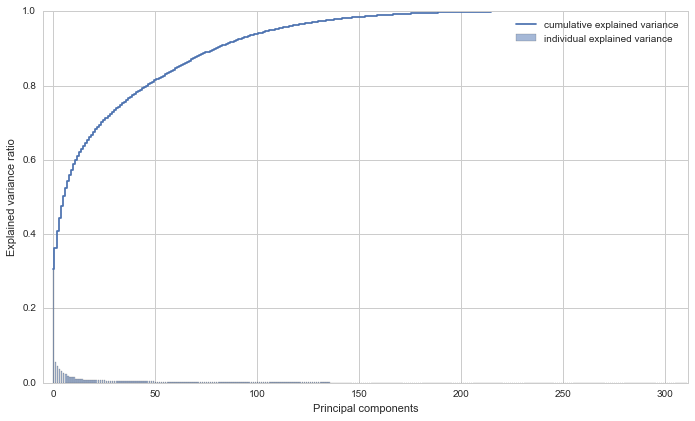

In [187]:
# Plot explained variance of eigenvalues
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 6))

    plt.bar(range(len(var_exp)), var_exp, alpha=0.5, align='center',label='individual explained variance')
    plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.xlim(-5,len(imputed_data.columns))
    plt.ylim(0,1)

In [ ]:
# Construct d x k eigenvector matrix
d = len(imputed_data.columns)
k = len(imputed_data.columns)#len([x for x in cum_var_exp if x < 0.95]) - drops low explained variance features
top_k = []
for pair in eig_pairs[:k]:
    top_k.append(pair[1].reshape(d,1))
matrix_w = np.hstack(top_k)

In [ ]:
# Transform dataset
pca_data = pd.DataFrame(data=imputed_data.dot(matrix_w),index=imputed_data.index)

# Since the remaining eigenvectors are real we can discard the imaginary parts
pca_data = pca_data.applymap(lambda x: float(x));

In [ ]:
# Transform test data
pca_test = pd.DataFrame(data=imputed_test.dot(matrix_w),index=imputed_test.index)

#### Feature Scaling
Below is my attempts to scale the data for linear regression before switching to random forest regression.

The first step is normalizing the data. The data that refer to financial values are scaled with a natural log first to better fit a normal distribution, then all the data is normalized.

In [ ]:
# List of all features in IPEDS data given in dollars
financial_features = ['tuition01','tuition02','tuition03','nettuition01','net_student_tuition','federal03','state03','local03',
                      'state_local_app','federal07','federal07_net_pell','state06','local06','state_local_grant_contract',
                      'federal10','federal10_net_pell','state09','fed_state_loc_grants_con','private03','affiliate01',
                      'investment01','endowment03','priv_invest_endow','edactivity03','auxiliary03','hospital03','other03',
                      'other04','independent03','other05','auxother_rev','stable_operating_rev','total03_revenue',
                      'tot_rev_wo_auxother_sum','tot_rev_w_auxother_sum','unrestricted_revenue','restricted_revenue',
                      'appliedaid01','appliedaid02','grant01','grant02','grant03','grant04','grant05','grant06','grant07',
                      'institutional_grant_aid','institutional_grant_aid_share','tuition_discount','instruction01',
                      'instruction01_fasb','instruction02','research01','research01_fasb','research02','pubserv01',
                      'pubserv01_fasb','pubserv02','acadsupp01','acadsupp01_fasb','acadsupp02','studserv01','studserv01_fasb',
                      'studserv02','instsupp01','instsupp01_fasb','instsupp02','opermain01','opermain01_fasb','opermain02',
                      'depreciation01','grants01u','grants01r','grants01','grants01_fasb','auxiliary01','auxiliary01_fasb',
                      'auxiliary02','hospital01','hospital01_fasb','hospital02','independ01','independ01_fasb','independ02',
                      'otheroper01','otheroper02','totaloper01','totaloper02','totaloper03','totaloper04','totaloper05',
                      'interest01','othernon01','othernon02','other01','other01_fasb','other02','totalnon01','totalnon02',
                      'total01','total02','total03_expenses','total04','total05','total06','total07','eandg01','eandg01_sum',
                      'eandg01_w_auxother_sum','eandg02','eandg03','eandg03a','eandg03b','eandg04','eandg05','eandg06','eandg07',
                      'eandg08','rschpub01','acadinststud01','acadinstsupp01','education_share','noneducation_share',
                      'other_ed_related_cost','instruction_share','studserv_share','admin_share','eandr','eandr_degree',
                      'eandr_completion','research_share','research_related_cost','pubserv_share','pubserv_related_cost',
                      'research_pubserv_grants','auxother_cost','sticker_subsidy','average_subsidy','sticker_price_share',
                      'gross_auxiliary_margin','gross_operating_margin','assets06','liabilities07','assets11','land04',
                      'buildings05','equipment05','assets15','endow02m','assets16','ft_faculty_salary']

non_financial_features = [x for x in ipeds_features if x not in financial_features]

In [ ]:
# Returns a natural log transformation with the mean centered on 0
def scale_and_center(series):
    minimum = series.min()
    if minimum <= 0:
        a = abs(minimum) + .001
    else:
        a = 0
    scaled_series = series.apply(lambda x: np.log(x+a))
    mn = np.nanmean(scaled_series)
    return scaled_series.apply(lambda x: x-mn)

In [ ]:
# Scale all financial data to constant 2012 dollars, then discard the scalar
hepi = data.loc[:,hepi_scalar]
financial_data = data.loc[:,financial_features].div(hepi, axis=0)
financial_data[non_financial_features] = data.loc[:,non_financial_features]
financial_data['cost'] = data.loc[:,'cost']

In [ ]:
# Scale all financial data with a natural log. Data with negative values are raised to min(data) == 0.001
financial_data.loc[:,financial_features] = financial_data.loc[:,financial_features].apply(scale_and_center)

#### Outlier Removal
Below is an attempt at liberal outlier removal. It was too aggressive, and not relevant once I switched to using a random forest.

In [ ]:
# Outlier removal
trimmed_data = pd.DataFrame(data = financial_data)
for feature in trimmed_data:
    Q1 = np.nanpercentile(trimmed_data[feature],25)
    Q3 = np.nanpercentile(trimmed_data[feature],75)
    step = 1.5*(Q3-Q1)
    trimmed_data = trimmed_data.drop(trimmed_data[~(np.isnan(trimmed_data[feature])) & 
                                                  ~((trimmed_data[feature] >= Q1 - step) & 
                                                    (trimmed_data[feature] <= Q3 + step))].index)
print trimmed_data.shape

#### Imputation based on univariate analysis
Below is a method I wrote to test the F-score of a feature imputed by the mean, median or zero. The idea was to select the method that gave the best information, but it never outperformed simply imputing zero.

In [ ]:
from sklearn.feature_selection import f_regression

# Impute null values with best of feature mean, median or zero based on F-score.
def impute_data(df,target):
    imputed_data = pd.DataFrame(index=df.index,columns=df.columns)
    
    # Impute data with three methods
    mdn = df.apply(lambda x: x.fillna(x.median()))
    mean = df.apply(lambda x: x.fillna(x.mean()))
    zero = df.fillna(0)
    
    # Compute resulting f score for each method
    mdn_scores = f_regression(mdn,target)[0]
    mean_scores = f_regression(mean,target)[0]
    zero_scores = f_regression(zero,target)[0]
    
    # Associate scores with feature keys
    scores = zip(df.columns,mdn_scores,mean_scores,zero_scores)
    
    # This is computationally expensive so here I record the best score per feature to avoid repeating the process
    imp_method = []
    
    # Fill dataframe with highest scoring imputation of each feature
    for score in scores:
        best_score = max(score[1],score[2],score[3])
        
        if best_score == score[1]:
            imputed_data.loc[:,score[0]] = mdn.loc[:,score[0]]
            imp_method.append((score[0],'median'))
        elif best_score == score[2]:
            imputed_data.loc[:,score[0]] = mean.loc[:,score[0]]
            imp_method.append((score[0],'mean'))
        else:
            imputed_data.loc[:,score[0]] = zero.loc[:,score[0]]
            imp_method.append((score[0],'zero'))

    return imputed_data,imp_method

In [ ]:
# Transform test data when using complicated imputation method
imp_test = pd.DataFrame(index=X_test.index,columns=X_test.columns)
for item in imp_methods:
    imp_test.loc[:,item[0]] = impute_series(X_test[item[0]],method=item[1])